# **Deep Learning Ex-2**

**Tomer Zamir**

**ID: 316123181**

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as ssn
import os

#For data preparation and preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
#For model creation and training
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

#For model evaluation
from sklearn.metrics import confusion_matrix


download dataset from kaggle API

In [4]:
# upload kaggle.json file, download from kaggle->account->Create New API Token
# alternetivly downloaded the dataset from the link below and skip this and the next 3 blocks.
# https://www.kaggle.com/datasets/puneet6060/intel-image-classification
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tomerzamir","key":"c5923d600d5c0bc57c677d566b0c48e1"}'}

In [5]:
import json

with open('/content/kaggle.json') as f:
    kaggle_api_key = json.load(f)
    
kaggle_api_key.keys()


dict_keys(['username', 'key'])

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('puneet6060/intel-image-classification', path='.', unzip=True)

data pre-processing

In [8]:
TRAIN_DIR = './seg_train/seg_train'
TEST_DIR = './seg_test/seg_test'
#seg_pred = './seg_pred'

In [9]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=5,
    zoom_range=(0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format="channels_last",
    validation_split=0.0,
    dtype=tf.float32,
)

In [10]:
BATCH_SIZE = 32
IMG_SIZE = 150

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rescaled = ImageDataGenerator(rescale=1.0 / 255,
    rotation_range=5,
    zoom_range=(0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format="channels_last",
    validation_split=0.0,
    dtype=tf.float32)
train_fed = tf.keras.utils.image_dataset_from_directory(TRAIN_DIR, image_size = (IMG_SIZE,IMG_SIZE), batch_size=32, label_mode = 'categorical', subset='training', validation_split = 0.2, seed=42)
test_fed = tf.keras.utils.image_dataset_from_directory(TEST_DIR, image_size = (IMG_SIZE,IMG_SIZE), batch_size=32, label_mode = 'categorical', subset='validation', validation_split = 0.2, seed=42)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


model

In [12]:
def define_model(k):
    filter_size=3
    stride=1
    rf=3
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3),
                     strides=(stride,stride)))
    while rf<k:
        rf+=(filter_size-1)*stride
        model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3),
                         strides=(stride,stride)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    print('Receptive Field =',rf)
    return model


In [17]:
model = define_model(k=30) # k must be at least 30 in order to get over 500,000 parameters
# in order to speed up the model - lower k

Receptive Field = 31


In [18]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 conv2d_22 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 batch_normalization_20 (Bat  (None, 150, 150, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 150, 150, 64)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 batch_normalization_21 (Bat  (None, 150, 150, 64)     256       
 chNormalization)                                     

In [21]:
history = model.fit(train_fed, shuffle=True, epochs=10, validation_data=test_fed, verbose=1,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy' ,patience=2,restore_best_weights=True))

Epoch 1/10
351/351 [==============================] - 328s 934ms/step - loss: 0.7188 - accuracy: 0.7178 - val_loss: 1.5581 - val_accuracy: 0.5133
Epoch 2/10
351/351 [==============================] - 328s 933ms/step - loss: 0.6602 - accuracy: 0.7485 - val_loss: 0.9178 - val_accuracy: 0.6750
Epoch 3/10
351/351 [==============================] - 327s 932ms/step - loss: 0.6287 - accuracy: 0.7568 - val_loss: 0.7456 - val_accuracy: 0.7150
Epoch 4/10
351/351 [==============================] - 325s 925ms/step - loss: 0.6030 - accuracy: 0.7707 - val_loss: 1.3164 - val_accuracy: 0.5783
Epoch 5/10
351/351 [==============================] - 325s 926ms/step - loss: 0.5660 - accuracy: 0.7875 - val_loss: 0.7296 - val_accuracy: 0.7383
Epoch 6/10
351/351 [==============================] - 325s 926ms/step - loss: 0.5442 - accuracy: 0.7951 - val_loss: 0.6665 - val_accuracy: 0.7417
Epoch 7/10
351/351 [==============================] - 327s 932ms/step - loss: 0.5165 - accuracy: 0.8065 - val_loss: 0.8047 -

evaluation

In [22]:
eva1 = model.evaluate(test_fed)

print('Test Accuracy of model: {}'.format(eva1[1]))

19/19 [==============================] - 4s 207ms/step - loss: 0.6665 - accuracy: 0.7417
Test Accuracy of model: 0.7416666746139526


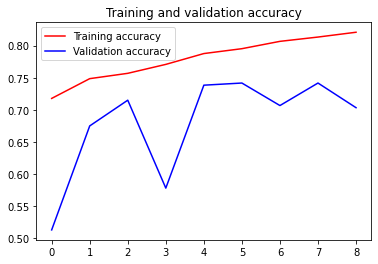

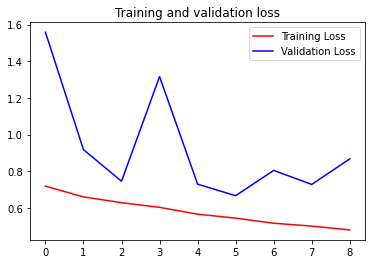

In [23]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()